# 0. Setup

In [1]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize, brentq, newton

from scipy.stats import norm, jarque_bera
from statsmodels.stats.diagnostic import lilliefors

import warnings
warnings.filterwarnings('ignore')



## 0.1 Helper Functions

In [2]:
### Covariance

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)

    #Calculate one column, then use this to populate rest of lower triangle of matrix
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))


In [3]:
#Data Manipulation

#This function needed because not all Brownian motion files start with 0, and they should for consistency
def add_zero(path):
    if path[0,] != 0:
        path = np.insert(path, 0, 0)
    return path
    
test1 = np.array([1, 2, 3])
test2 = np.array([0, -1, -2, -3])
assert_almost_equal(np.array([0, 1, 2, 3]), add_zero(test1))
assert_almost_equal(test2, add_zero(test2))

def get_diffs(path):
    # Get the differences of a path i.e. the individual increments
    return path[1:] - path[:-1]

assert_almost_equal(get_diffs(np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0, 0]))
assert_almost_equal(get_diffs(np.array([1, 2, 3, 4, 5])), np.array([1, 1, 1, 1]))

def second_order_diffs(path):
    return path[2:] - 2 * path[1:-1] + path[:-2]

assert_almost_equal(second_order_diffs(np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0]))
assert_almost_equal(second_order_diffs(np.array([1, 2, 3, 4, 5])), np.array([0, 0, 0]))

#Get spot variances in spanned sets of a path
def estimate_spot_variance(S_path, span):
    #Implicitly assuming we are looking at a range[0, 1]
    #Check can divide range into equal sub-sections
    #Assume path starts with 0 at time 0

    n_steps = S_path.shape[0] - 1
    assert_almost_equal(n_steps % span, 0)
    n_windows = n_steps / span
    delta_t = 1 / n_windows

    log_returns = np.log(S_path[1:]/S_path[:-1])
    spanned_returns = np.split(log_returns, n_windows)

    spot_variances = np.zeros(int(n_windows))

    for i, v in enumerate(spanned_returns):
        spot_variances[i] = np.dot(v, v) 

    return spot_variances

test_path = np.arange(1, 22)
assert_almost_equal(estimate_spot_variance(test_path, 10), np.array([0.8863009, 0.0432722]))



In [4]:
## Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def get_IV_from_price(S, t, K, T, r, market_price):

    def black_scholes_call_price(sigma):
        d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
        call_price = (S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2))
        return call_price - market_price

    return brentq(black_scholes_call_price, 1e-10, 100, maxiter = 500)

assert_almost_equal(get_IV_from_price(100, 0, 100, 1, 0, 7.96558 ), 0.2, decimal = 5)
assert_almost_equal(get_IV_from_price(100, 0, 90, 1, 0, 34.77223 ), 0.8, decimal = 5)


In [25]:
## Simulation

def simulate_bm_fbm(n_sims, n_steps, T, H, rng = None, do_both_paths = True):
    #returns B and BH paths; both needed for simulation later

    if rng is None:
        rng = np.random.default_rng(seed = 1729)
    
    variates = rng.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    B_path = None
    BH_path = np.zeros([n_sims, n_steps + 1])

    delta = (T / n_steps)

    if do_both_paths or H == 0.5:
        B_path = np.zeros([n_sims, n_steps + 1])
        for i in range(0, n_steps):
            B_path[:, i + 1] = B_path[:, i] + delta ** 0.5 * variates[:, i]

    if H != 0.5:
        print('Beginning Simulation')
        cov_mat = get_covariance_matrix(n_steps, H)
        L = np.linalg.cholesky(cov_mat)
        print('Covariance Done')
        corr_variates = (L @ variates.T).T
    
        for i in range(0, n_steps):
            BH_path[:, i + 1] = BH_path[:, i] + corr_variates[:, i] * delta ** H
    else:
        BH_path = B_path

    return B_path, BH_path


Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done


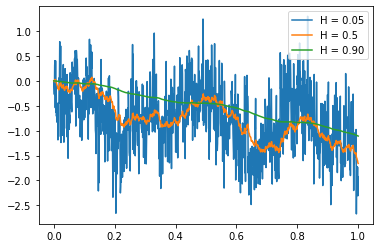

In [26]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_bm_fbm(1, n_steps, T, 0.05)[1]
plt.plot(span, out.T, label = "H = 0.05")

out = simulate_bm_fbm(1, n_steps, T, 0.5)[1]
plt.plot(span, out.T, label = "H = 0.5")

out = simulate_bm_fbm(1, n_steps, T, 0.95)[1]
plt.plot(span, out.T, label = "H = 0.90")

plt.legend()

In [27]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 

    q = 2

    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = np.abs(x[1:] - x[:-1])
    n_steps = diffs.shape[0]

    return np.log(1/n_steps * np.sum(diffs ** q)) / (q * np.log(T / n_steps))


# 1. MLE

In [31]:
def obj(H, x, T, scalar = None):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)

    if scalar is None: 
       scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant)  + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) + n_steps * np.log(scalar)

def max_MLE(x, T, scalar = None):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]
    n_steps = diffs.shape[0]
    
    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T, scalar), bounds = [(np.finfo(float).eps, 0.95)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        if scalar is None:
            scalar = (T / n_steps) ** (2 * H_hat)
            R_inv = np.linalg.inv(R)
            sigma_hat = np.sqrt(1 / (n_steps * scalar) * np.dot(diffs.T, np.dot(R_inv, diffs)))
        else:
            sigma_hat = scalar
        return H_hat, sigma_hat

    return H.success

In [38]:
# Check this code works for a selection of cases
def test_MLE_no_scalar():
    test_vals = np.arange(0.05, 0.15, 0.1)
    test_scalars = np.arange(1, 1.5, 0.5)
    val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
    scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
    for i, i_val in enumerate(test_vals):
        for j, j_val in enumerate(test_scalars):
            print(i_val, j_val)
            test_sim = simulate_bm_fbm(1, 2048, 1, i_val)[1]
            test_sim = test_sim[0, :].T * j_val
            test_H = max_MLE(test_sim, 1)
            val_errors[i, j] = test_H[0] - i_val
            scalar_errors[i, j] = test_H[1] - j_val
            
    return val_errors, scalar_errors

In [39]:
val_errors, scalar_errors = test_MLE_no_scalar()

0.05 1.0
Beginning Simulation
Covariance Done


In [41]:
val_errors

array([[-0.04999999]])

In [156]:
def obj_old(H, x, T, scalar = None):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    if scalar is None: 
       scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant)  + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) + n_steps * np.log(scalar)
    


def max_MLE_old(x, T, scalar = None):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]
    n_steps = diffs.shape[0]
    
    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj_old, initial_guess, args = (diffs, T, scalar), bounds = [(np.finfo(float).eps, 0.95)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        if scalar is None:
            scalar = (T / n_steps) ** (2 * H_hat)
            R_inv = np.linalg.inv(R)
            sigma_hat = np.sqrt(1 / (n_steps * scalar) * np.dot(diffs.T, np.dot(R_inv, diffs)))
        else:
            sigma_hat = scalar
        return H_hat, sigma_hat

    return H.success

In [154]:
test_vals = np.arange(0.05, 0.35, 0.1)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    print(i_val)
    for j, j_val in enumerate(test_scalars):
        print(j_val)
        test_sim = simulate_bm_fbm(1, 1024, 1, i_val)[1]        
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE_old(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val

0.05
0.5
Beginning Simulation
Covariance Done
1.0
Beginning Simulation
Covariance Done
1.5
Beginning Simulation
Covariance Done
0.15000000000000002
0.5
Beginning Simulation
Covariance Done
1.0
Beginning Simulation
Covariance Done
1.5
Beginning Simulation
Covariance Done
0.25000000000000006
0.5
Beginning Simulation
Covariance Done
1.0
Beginning Simulation
Covariance Done
1.5
Beginning Simulation
Covariance Done


In [155]:
val_errors

array([[0.0028441 , 0.0028441 , 0.00284412],
       [0.00276499, 0.002765  , 0.00276498],
       [0.00334685, 0.00334684, 0.00334684]])

In [ ]:
test_vals = np.arange(0.05, 0.15, 0.05)
test_scalars = np.arange(1)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    for j, j_val in enumerate(test_scalars):
        test_sim = simulate_fbm_old(1, 1024, 1, i_val)
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val

TypeError: 'bool' object is not subscriptable

In [ ]:
val_errors

array([[0.00284412, 0.00284411, 0.00284412],
       [0.00267592, 0.00267592, 0.00267592]])

In [ ]:
val_errors

array([[0.01313024, 0.01313024, 0.01313022],
       [0.02088725, 0.02088725, 0.02088725]])

In [ ]:
# sample_fbm = np.loadtxt('/Users/james.male/Dissertation/fBMPath2.txt')
sample_fbm = np.loadtxt('C:\\Users\\jamma\Masters\\Dissertation\\fBMPath2.txt')
res = max_MLE(sample_fbm, 1)
res



(0.0356754412027325, 1.159697945219666)

Beginning Simulation
Covariance Done


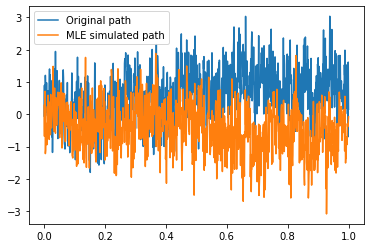

In [ ]:
comparison = res[1] * simulate_bm_fbm(1, 1024, 1, res[0])[1]

plt.plot(np.linspace(0, 1, 1024), sample_fbm, label = 'Original path')
plt.plot(np.linspace(0, 1, 1024), comparison[0, 1:], label = 'MLE simulated path')
plt.legend()

In [ ]:
print (np.mean(comparison[0, 1:]), np.mean(sample_fbm))
print(np.std(comparison[0, 1:]),  np.std(sample_fbm))
print(np.min(comparison[0, 1:]),  np.min(sample_fbm))
print(np.max(comparison[0, 1:]),  np.max(sample_fbm))


-0.45645709705730114 0.6045443586353594
0.7499051731947557 0.7909821547861726
-3.090024141277566 -1.802834383774
1.8864994866446247 3.038877323643


# 2. Simulation

### 2.1 With given Paths

In [ ]:
class RFSV_model:
    def __init__(self, V0, S0, V, rho, H, T, B_path, BH_path, W_path, window_length):
        #inputs
        self.V0 = V0
        self.S0 = S0
        self.V = V
        self.rho = rho
        self.rho_bar = np.sqrt(1 - rho ** 2)
        self.window_length = window_length
        self.H = H
        self.T = T

        #Derived
        self.B_path = B_path
        self.BH_path = BH_path
        self.W_path = W_path
        
        self.n_steps = self.B_path.shape[0] - 1
        self.delta = self.T * self.window_length / self.n_steps


    def run_H_estimation(self):
        self.simulate_RFSV()
        self.variance_estimation()
        return self.est_H, self.MLE_H, self.realised_H
    
    def simulate_RFSV(self):
        
        B_diffs = get_diffs(self.B_path)
        W_diffs = get_diffs(self.W_path)

        S_path = np.zeros(self.n_steps + 1)
        V_path = np.zeros(self.n_steps + 1)

        V_path = self.V0 * np.exp(self.V * self.BH_path)
        S_path[0] = self.S0
        
        for i in range(self.n_steps):
            S_path[i + 1] = S_path[i] *\
                (1 + np.sqrt(V_path[i]) *\
                (self.rho * B_diffs[i] + self.rho_bar * W_diffs[i]))
        
        self.V_path = V_path
        self.S_path = S_path

    def variance_estimation(self):
        est_V = estimate_spot_variance(self.S_path, self.window_length)

        V0_estimate = np.exp(np.mean(np.log(est_V)))
        log_est_V = add_zero(np.log(est_V / V0_estimate))

        #This gives us a variance process up to time 1 - delta
        self.est_H = H_estimator(log_est_V, 1)

        self.realised_H = H_estimator(add_zero(np.log(self.V_path / self.V0)), 1)

        self.MLE_H = max_MLE(add_zero(est_V/self.V0), 1, scalar = self.V)[0]

In [ ]:
B_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.05.txt'
BH_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.05.txt'
W_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.05.txt'

# B_path_loc_05 = '/Users/james.male/Dissertation/Bpath.05.txt'
# BH_path_loc_05 = '/Users/james.male/Dissertation/BHpath.05.txt'
# W_path_loc_05 = '/Users/james.male/Dissertation/Wpath.05.txt'

B_path_05 = add_zero(np.loadtxt(B_path_loc_05))
BH_path_05 = add_zero(np.loadtxt(BH_path_loc_05))
W_path_05 = add_zero(np.loadtxt(W_path_loc_05))

window_lengths = [16, 32, 64]

for window_length in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.05, 1, B_path_05, BH_path_05, W_path_05, window_length)

    est_H, MLE_H, realised_H = test.run_H_estimation()
    print(est_H, MLE_H, realised_H)


0.06068738043960221 0.031720964345314955 0.05058175194263949
0.10767166651786558 0.06049473953210829 0.05058175194263949
0.1945141473667977 0.13620489648860215 0.05058175194263949


In [ ]:
# B_path_loc_05 = '/Users/james.male/Dissertation/Bpath.10.txt'
# BH_path_loc_05 = '/Users/james.male/Dissertation/BHpath.10.txt'
# W_path_loc_05 = '/Users/james.male/Dissertation/Wpath.10.txt'

B_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.10.txt'
BH_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.10.txt'
W_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.10.txt'

B_path_10 = add_zero(np.loadtxt(B_path_loc_10))
BH_path_10 = add_zero(np.loadtxt(BH_path_loc_10))
W_path_10 = add_zero(np.loadtxt(W_path_loc_10))

window_lengths = [16, 32, 64]

for window in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.1, 1, B_path_10, BH_path_10, W_path_10, window)

    est_H, MLE_H, realised_H = test.run_H_estimation()
    print(est_H, MLE_H, realised_H)


0.08161212656954556 0.0667212853087558 0.10233969211163327
0.1362344310480667 0.12015957811867606 0.10233969211163327
0.18482698451822696 0.1546233691751344 0.10233969211163327


### 2.2 H = 0.5, 100 paths

In [ ]:
def run_half_H_case():

    n_sims = 100
    n_steps = 2 ** 16

    simulated_H = np.zeros(n_sims)
    sim_MLE_H = np.zeros(n_sims)
    sim_realised_H = np.zeros(n_sims)

    S0 = 1
    v = 1
    rho = -0.65
    V0 = 0.1
    window_length = 512

    rng = np.random.default_rng(seed = 1729)
    B_paths = simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]
    rng = np.random.default_rng(seed = 42)
    W_paths = simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]

    for i in range(n_sims):
        if (i + 1) % 5 == 0:
            print(f"{(i + 1) / 100:.0%}")
        model = RFSV_model(V0, S0, v, rho, 0.5, 1, B_paths[i, :], B_paths[i, :], W_paths[i, :], window_length)
        est_H, MLE_H, realised_H = model.run_H_estimation()

        simulated_H[i] = est_H
        sim_MLE_H[i] = MLE_H
        sim_realised_H[i] = realised_H

    plt.hist(sim_MLE_H)

    return sim_MLE_H, sim_realised_H


sim_MLE_H, sim_realised_H = run_half_H_case()

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


(array([ 4., 13., 24., 22., 25.,  5.,  3.,  0.,  3.,  1.]),
 array([0.20219087, 0.24947068, 0.2967505 , 0.34403031, 0.39131013,
        0.43858994, 0.48586975, 0.53314957, 0.58042938, 0.6277092 ,
        0.67498901]),
 <BarContainer object of 10 artists>)

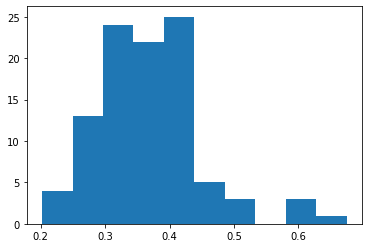

In [ ]:
plt.hist(sim_MLE_H)

(array([ 7.,  4.,  9., 15., 22., 20., 11.,  5.,  4.,  3.]),
 array([0.4995255 , 0.49962769, 0.49972988, 0.49983207, 0.49993427,
        0.50003646, 0.50013865, 0.50024084, 0.50034303, 0.50044523,
        0.50054742]),
 <BarContainer object of 10 artists>)

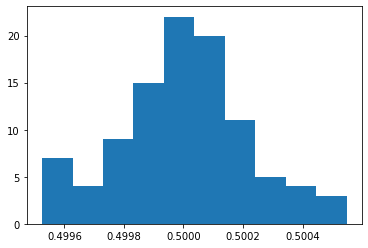

In [ ]:
plt.hist(sim_realised_H)

In [ ]:
print(np.mean(sim_MLE_H))
print(np.std(sim_MLE_H))
print(np.mean(sim_MLE_H) - 0.5)

print(np.mean(sim_MLE_H) + np.std(sim_MLE_H)* norm.ppf(0.025))
print(np.mean(sim_MLE_H) + np.std(sim_MLE_H)* norm.ppf(0.975))

0.36944783918844026
0.08402242845057954
-0.13055216081155974
0.20476690553171076
0.5341287728451698


In [ ]:
print(np.mean(sim_realised_H))
print(np.std(sim_realised_H))
print(np.mean(sim_realised_H) - 0.5)

print(np.mean(sim_realised_H) + np.std(sim_realised_H)* norm.ppf(0.025))
print(np.mean(sim_realised_H) + np.std(sim_realised_H)* norm.ppf(0.975))

0.5000032587630908
0.00021983072330728813
3.2587630908187393e-06
0.4995723984627131
0.5004341190634685


### 2.3 Monte Carlo Pricing

In [ ]:
def MC_Pricing_RFSV():

    n_sims = 10000
    n_steps = 2 ** 14 #consistent with simulated sample paths

    S0 = 1
    v = 1
    rho = 0.65
    V0 = 0.04
    H = 0.1
    dummy_window_length = 512

    log_moneyness = np.arange(-0.5, 0.55, 0.05)
    call_prices = np.zeros(log_moneyness.shape)
    IVs = np.zeros(log_moneyness.shape)

    rng = np.random.default_rng(seed = 1729)
    B_sim, BH_sim = simulate_bm_fbm(int(n_sims / 2), n_steps, 1, H, rng)
    rng = np.random.default_rng(seed = 42)
    W_sim = simulate_bm_fbm(int(n_sims / 2), n_steps, 1, 0.5, rng)[0]
    print('Simulation done')

    B_paths = np.vstack((B_sim, -B_sim))
    BH_paths = np.vstack((BH_sim, -BH_sim))
    W_paths = np.vstack((W_sim, -W_sim))
    S1_paths = np.zeros([n_sims, 1])

    for i in range  (n_sims):
        if (i + 1) % 500 == 0:
            print(f"{(i + 1) / n_sims:.0%}")
        model = RFSV_model(V0, v, S0, rho, 0.1, 1, B_paths[i, :], B_paths[i, :], W_paths[i, :], dummy_window_length)
        model.simulate_RFSV()
        S1_paths[i] = model.S_path[-1]

    for i, v in enumerate(log_moneyness):
        strike = S0 * np.exp(v)
        call_prices[i] = np.average(np.maximum(S1_paths - strike, 0))
        IVs[i] = get_IV_from_price(S0, 0, strike, 1, 0, call_prices[i])

    plt.plot(log_moneyness, IVs)
    return IVs

MC_Pricing_RFSV()

Beginning Simulation
Covariance Done
Simulation done
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


ValueError: f(a) and f(b) must have different signs

In [ ]:
for i, v in enumerate(log_moneyness):
    strike = S0 * np.exp(v)
    call_prices[i] = np.average(np.maximum(S1_paths - strike, 0))
    IVs[i] = get_IV_from_price(S0, 0, strike, 1, 0, call_prices[i])

IVs

array([0.2874673 , 0.28102799, 0.27384772, 0.26619736, 0.25863975,
       0.25122686, 0.24327178, 0.23483466, 0.22629631, 0.21801037,
       0.21031933, 0.20278444, 0.19559277, 0.1892253 , 0.18428023,
       0.18004293, 0.17675337, 0.17459989, 0.17364361, 0.17315925,
       0.17436045])

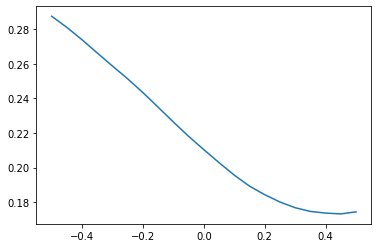

In [ ]:
plt.plot(log_moneyness, IVs)

# 3. Further Estimation

In [ ]:
SPX_path = "C:\\Users\\jamma\\Masters\\Dissertation\\SPX3yrDailyRealizedVariance1minBins.txt"

In [ ]:
SPX_path = np.loadtxt(SPX_path)
df_describe = pd.DataFrame(SPX_path)
df_describe.describe()

,0
count,792.000000
mean,0.045429
std,0.119987
min,0.001346
25%,0.008999
50%,0.019922
75%,0.040742
max,2.102486


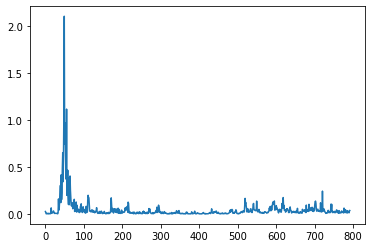

In [ ]:
plt.plot(SPX_path)

In [ ]:
def make_SPX_graphs(SPX_data, V0_input = None, make_graphs = True):

    if V0_input is None:
        V0_input = np.exp(np.mean(np.log(SPX_data)))

    SPX_adjusted = add_zero(np.log(SPX_data / V0_input ))
    
    H_hat_SPX, sigma_hat_SPX = max_MLE(SPX_adjusted, SPX_adjusted.shape[0])
    span = np.linspace(0, SPX_adjusted.shape[0], SPX_adjusted.shape[0])
    out = simulate_bm_fbm(1, SPX_adjusted.shape[0] - 1, SPX_adjusted.shape[0] - 1, H_hat_SPX)[1]
    
    if make_graphs:
        plt.figure(0)
        plt.plot(SPX_adjusted)
        plt.show()

        plt.figure(1)
        plt.subplot(211)
        plt.plot(span, SPX_adjusted)
        plt.subplot(212)
        plt.plot(span, out.T * sigma_hat_SPX)
        plt.show()

    return H_hat_SPX, sigma_hat_SPX, V0_input



Beginning Simulation
Covariance Done


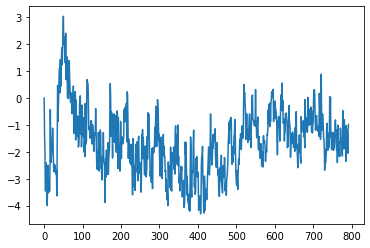

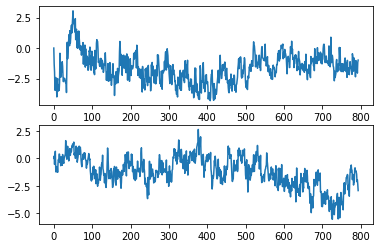

(0.21262807646853785, 0.7081133722188383, 0.1)

In [ ]:
#Approach 1 - assume V0 is as given in model

V0_given = 0.1

make_SPX_graphs(SPX_path, V0_given)



Beginning Simulation
Covariance Done


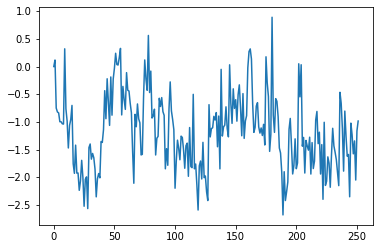

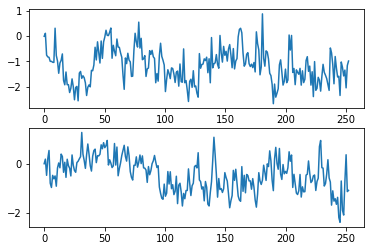

(0.14425240637238937, 0.6139235873235436, 0.1)

In [ ]:

make_SPX_graphs(SPX_path[-251:], V0_given)

Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
B

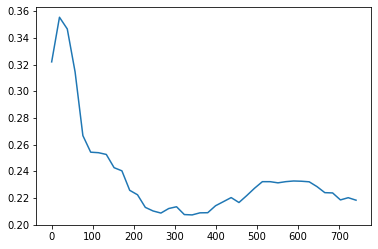

In [ ]:
rolling_H = np.zeros(40)
span = np.zeros(40)

for i in range(40):
    rolling_H[i] = make_SPX_graphs(SPX_path[19 * i:], V0_given, make_graphs = False)[0]
    span[i] = len(SPX_path) - 19 * i

plt.plot(span, rolling_H)


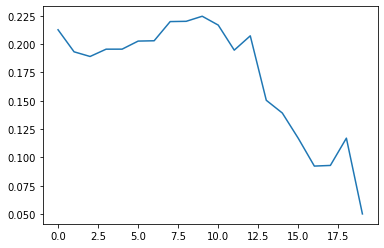

In [ ]:
plt.plot(range(20), rolling_H)

# 4 Own investigation

### 4.0 Setup

In [ ]:
class estimator_master():
    def __init__(self,
        n_sims = 5_000,
        n_steps = 2 ** 14,
        H_values = np.array([0.5]),
        do_convergence_tests = True,
        T = 1
        ):


        self.H_values = H_values
        self.H_simulated = np.zeros((n_sims, H_values.shape[0]))

        self.norm_checks_JB = np.zeros(H_values.shape)
        self.norm_checks_LF = np.zeros(H_values.shape)

        # Distribution Check
        self.n_sims = n_sims
        self.n_steps = n_steps
        self.T = T

        self.do_convergence_tests = do_convergence_tests

    def do_analysis(self):
        self.run_simulation()
        if self.do_convergence_tests:
            self.convergence_testing()
        self.do_analytics()

    def H_estimator(self):
        pass

    def run_simulation(self):

        fig, axs = plt.subplots(int(np.ceil(self.H_values.shape[0] / 4)), 4, figsize=(40, 20))
        
        
        for j, H in enumerate(self.H_values):
            print(H)
            out = simulate_bm_fbm(self.n_sims, self.n_steps, T, H, do_both_paths = False)[1]
            
            for i in range(out.shape[0]):
                if i % 1_000 == 0:
                    print(i)
                self.H_simulated[i, j] = self.H_estimator(out[i, :])

            self.norm_checks_JB[j] = jarque_bera(self.H_simulated[:, j]).pvalue
            self.norm_checks_LF[j] = lilliefors(self.H_simulated[:, j])[1]
        
            axs[int(np.floor(j / 4)), j % 4].hist(self.H_simulated[:, j], bins = 40, facecolor='blue', alpha=0.5)
            
            y = np.linspace(self.H_simulated[:, j].min(), self.H_simulated[:, j].max(), 1000)
            bin_width = (self.H_simulated[:, j].max() - self.H_simulated[:, j].min()) / 40
            axs[int(np.floor(j / 4)), j % 4].plot(y, norm.pdf(y, loc = np.mean(self.H_simulated[:, j]), scale = np.std(self.H_simulated[:, j])) * self.n_sims * bin_width)
        
        fig.show()

        
    def convergence_testing(self):

        exponents = np.arange(3, 13, 1)
        self.H_by_density = np.zeros((len(self.H_values), len(exponents)))
        n_sims = 5_000

        fig, axs = plt.subplots(int(np.ceil(self.H_values.shape[0] / 4)), 4, figsize=(40, 20))

        for i, H in enumerate(self.H_values):
            print(H)
            out = simulate_bm_fbm(n_sims, int(2 ** (exponents[-1])), 1, self.H_values[i], do_both_paths = False)[1]

            for j in range(len(exponents)):
                width = 2 ** (exponents[-1] - exponents[j])
                tmp_out = out[:, 0::width]
                tmp_estimators = np.zeros(n_sims)
            
                for k in range(out.shape[0]):
                    tmp_estimators[k] = self.H_estimator(tmp_out[k, :])
                
                self.H_by_density[i, j] = np.mean(tmp_estimators)
            
            axs[int(np.floor(i / 4)), i % 4].plot(exponents, np.log2(self.H_by_density[i, :]))
            axs[int(np.floor(i / 4)), i % 4].plot(exponents, np.tile(np.log2(H), len(exponents)))
            
        fig.show()
        
    def do_analytics(self):
        mean_H = np.zeros(self.H_values.shape)
        var_H = np.zeros(self.H_values.shape)
        for j, H in enumerate(self.H_values):
            mean_H[j] = np.mean(self.H_simulated[:, j])
            var_H[j] = np.var(self.H_simulated[:, j])
        self.df_analytics = pd.DataFrame(np.column_stack((mean_H, var_H)), index = self.H_values, columns = ["Mean", "Variance"])


### 4.1 Gladyshev

In [ ]:
class gladyshev_estimator(estimator_master):
    def H_estimator(self, x):

        #return estimator of H from dissertation. Assume q = 2. 
        q = 2

        if x[0,] != 0:
            x = np.insert(x, 0, 0)
        diffs = get_diffs(x)
        n_steps = diffs.shape[0]

        return np.log(1/n_steps * np.sum(diffs ** q)) / (q * np.log(self.T / n_steps))

0.05
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.1
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.2
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.3
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.4
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.5
0
1000
2000
3000
4000
0.6
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.7
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.8
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.9
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.05
Beginning Simulation
Covariance Done
0.1
Beginning Simulation
Covariance Done
0.2
Beginning Simulation
Covariance Done
0.3
Beginning Simulation
Covariance Done
0.4
Beginning Simulation
Covariance Done
0.5
0.6
Beginning Simulation
Covariance Done
0.7
Beginning Simulation
Covariance Done
0.8
Beginning Simulation
Covariance Done
0.9
Beginning Simulation
Covariance Done


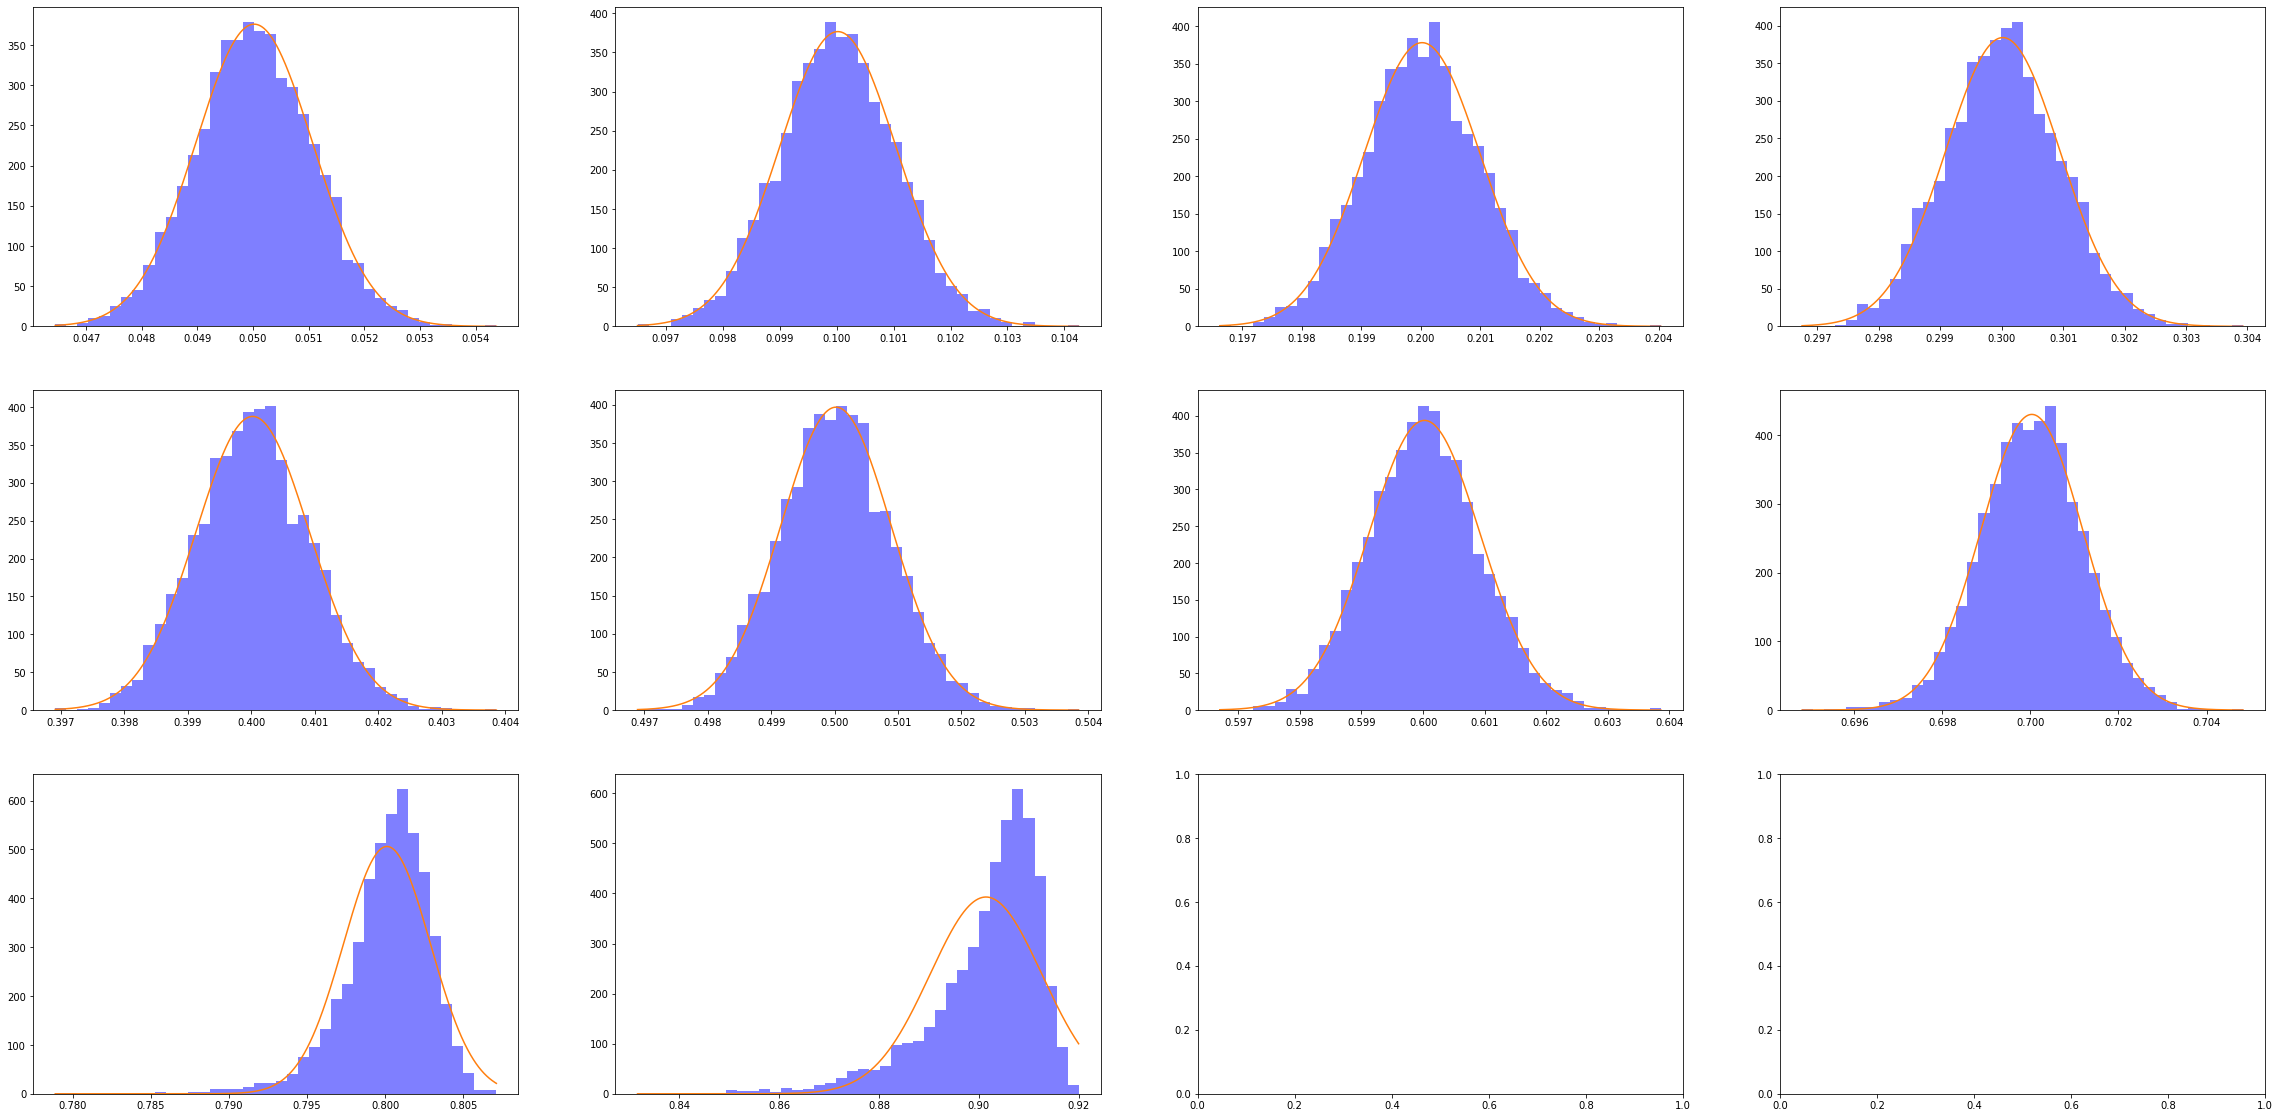

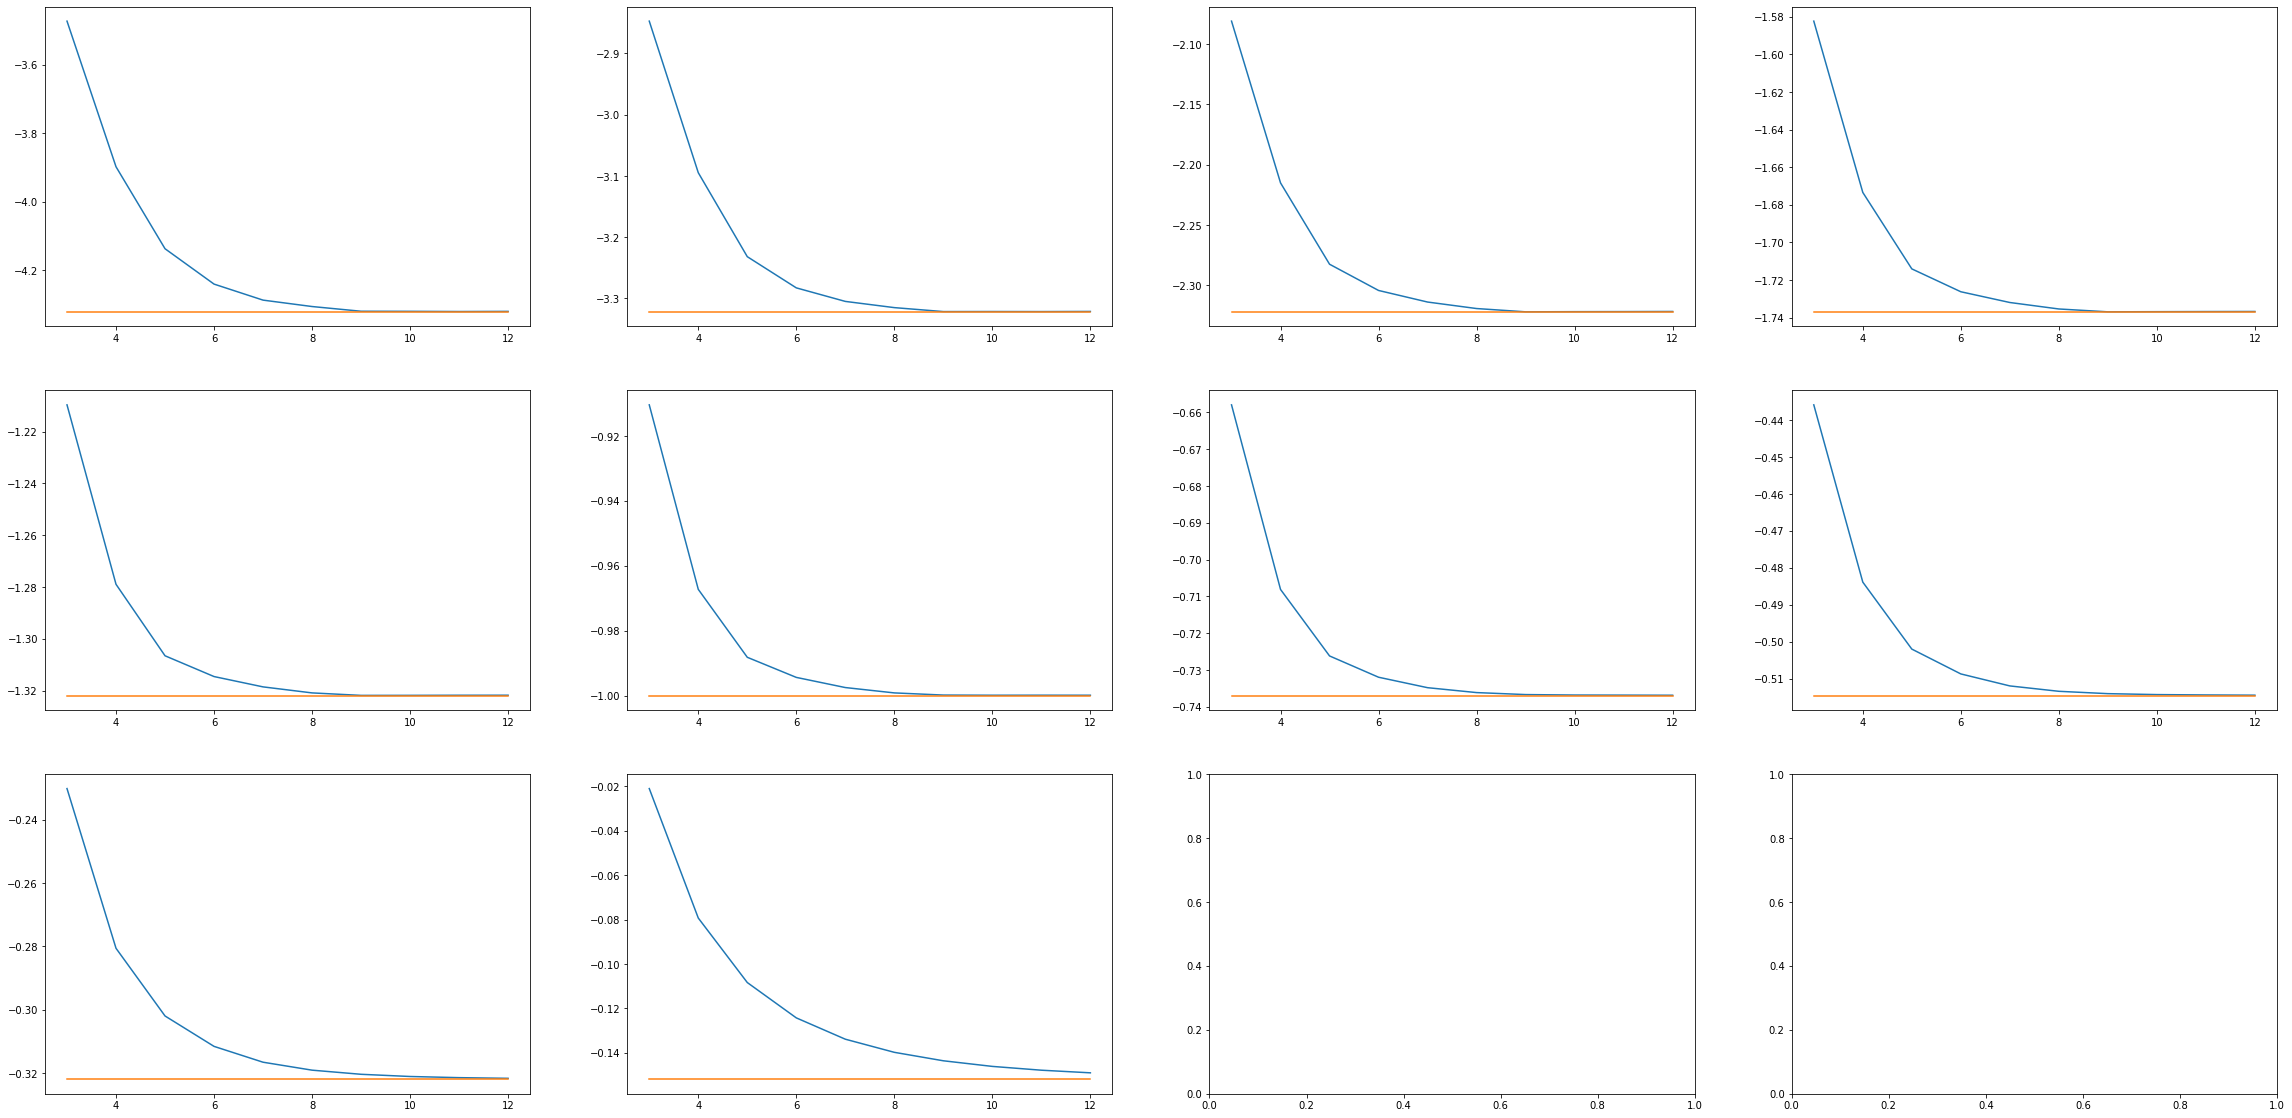

In [ ]:

glady = gladyshev_estimator(
    H_values = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 13,
)

glady.do_analysis()

In [ ]:
glady.df_analytics

,Mean,Variance
0.05,0.050020,1.105381e-06
0.10,0.100020,1.053934e-06
0.20,0.200019,9.559267e-07
0.30,0.300019,8.684313e-07
0.40,0.400020,7.990543e-07
0.50,0.500021,7.645689e-07
0.60,0.600023,8.222466e-07
0.70,0.700033,1.348582e-06
0.80,0.800115,7.748598e-06
0.90,0.901436,1.258683e-04


### 4.2 Coeurjolly 1

In [ ]:
class coeurjolly1(estimator_master):
    def H_estimator(self, x):

        n_steps = x.shape[0]
        x = add_zero(x)

        full_path_second_order = np.sum(second_order_diffs(x) ** 2)
        half_path_second_order = np.sum(second_order_diffs(x[::2]) ** 2)


        return 0.5 - 1 / ( 2 * np.log(2)) * np.log(full_path_second_order / half_path_second_order)

0.05
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.1
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.2
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.3
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.4
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.5
0
1000
2000
3000
4000
0.6
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.7
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.8
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.9
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.05
Beginning Simulation
Covariance Done
0.1
Beginning Simulation
Covariance Done
0.2
Beginning Simulation
Covariance Done
0.3
Beginning Simulation
Covariance Done
0.4
Beginning Simulation
Covariance Done
0.5
0.6
Beginning Simulation
Covariance Done
0.7
Beginning Simulation
Covariance Done
0.8
Beginning Simulation
Covariance Done
0.9
Beginning Simulation
Covariance Done


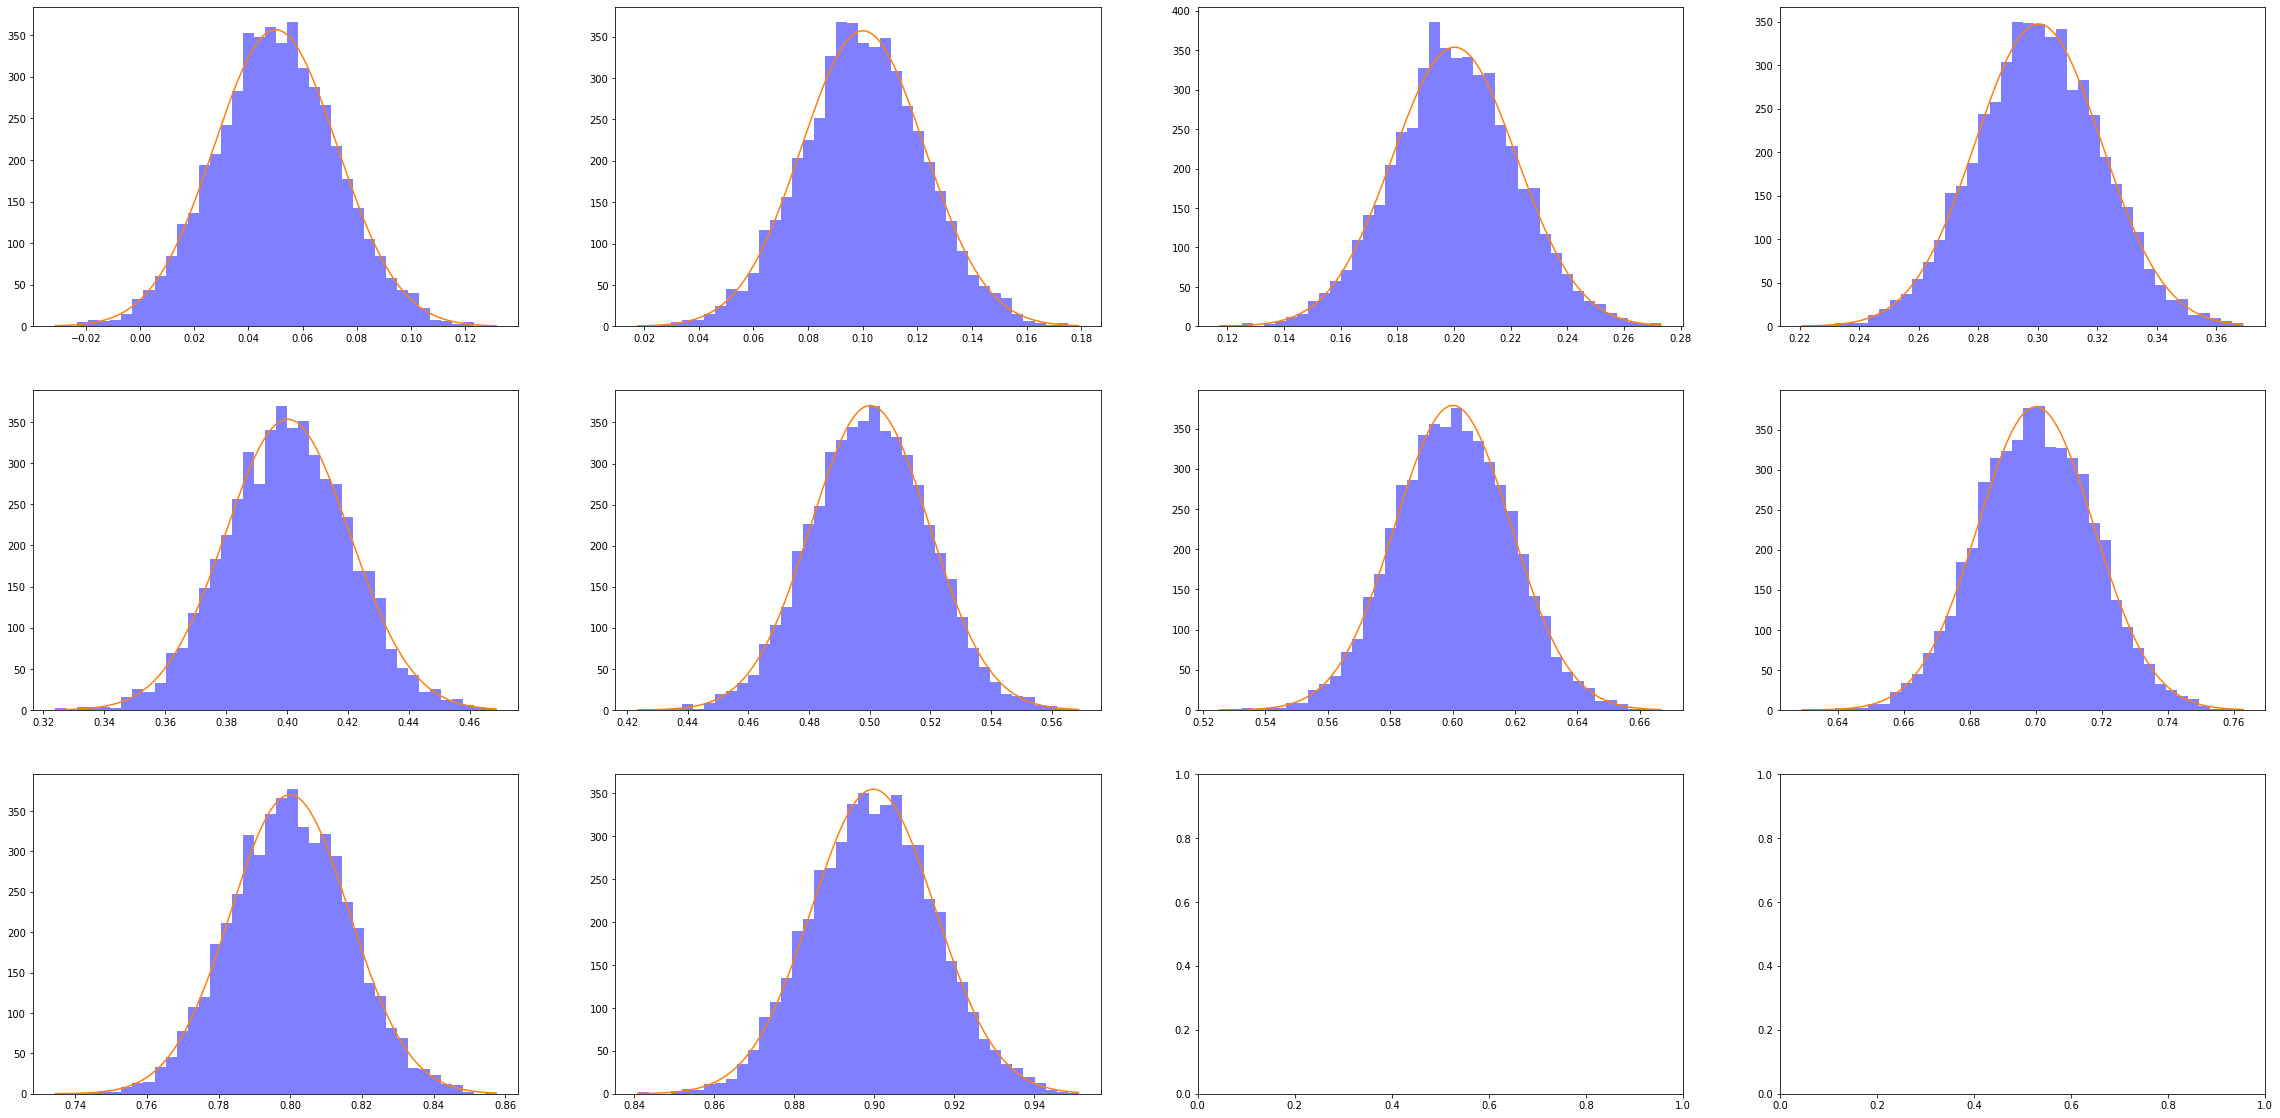

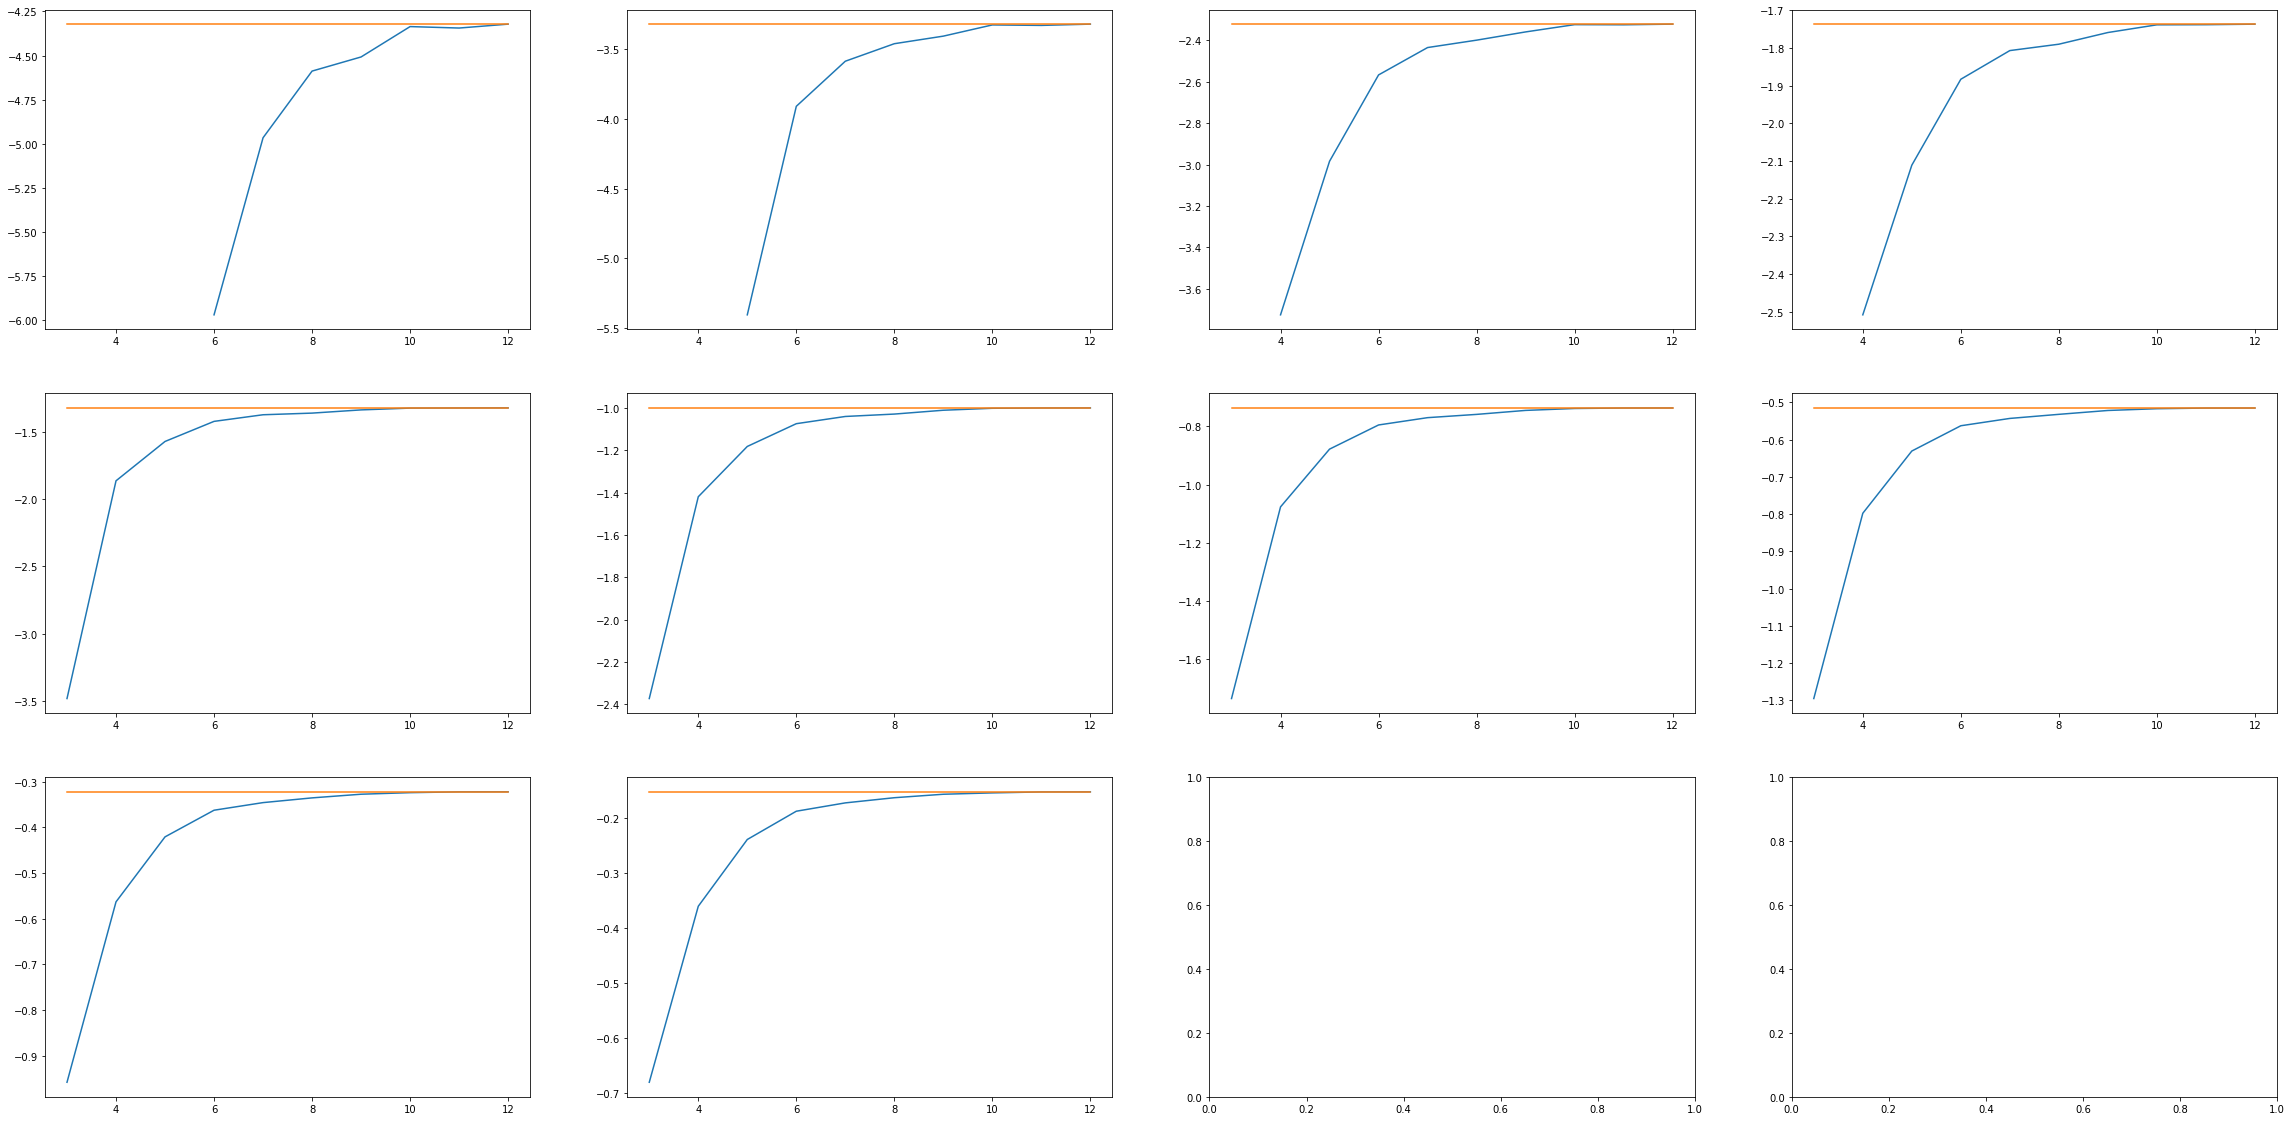

In [ ]:
coeur1 = coeurjolly1(
    H_values = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 13,
)

coeur1.do_analysis()

### 4.3 Coeurjolly 2

In [ ]:
class coeurjolly2(estimator_master):
    def H_estimator(self, x):

        n_steps = x.shape[0]
        def coeur_function(y):
            return (self.T / n_steps) ** (2 * y) * (4 - 2 ** (2 * y))

        x = add_zero(x)
        self.path_diffs = 1 / n_steps * np.sum(second_order_diffs(x) ** 2)

        def obj_coeur(z):
            return coeur_function(z) - self.path_diffs
        
        return brentq(obj_coeur, -1, 1, maxiter = 500)


In [ ]:
coeur2 = coeurjolly2(
    H_values = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 13,
)

0.05
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.1
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.2
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.3
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.4
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.5
0
1000
2000
3000
4000
0.6
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.7
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.8
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.9
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.05
Beginning Simulation
Covariance Done
0.1
Beginning Simulation
Covariance Done
0.2
Beginning Simulation
Covariance Done
0.3
Beginning Simulation
Covariance Done
0.4
Beginning Simulation
Covariance Done
0.5
0.6
Beginning Simulation
Covariance Done
0.7
Beginning Simulation
Covariance Done
0.8
Beginning Simulation
Covariance Done
0.9
Beginning Simulation
Covariance Done


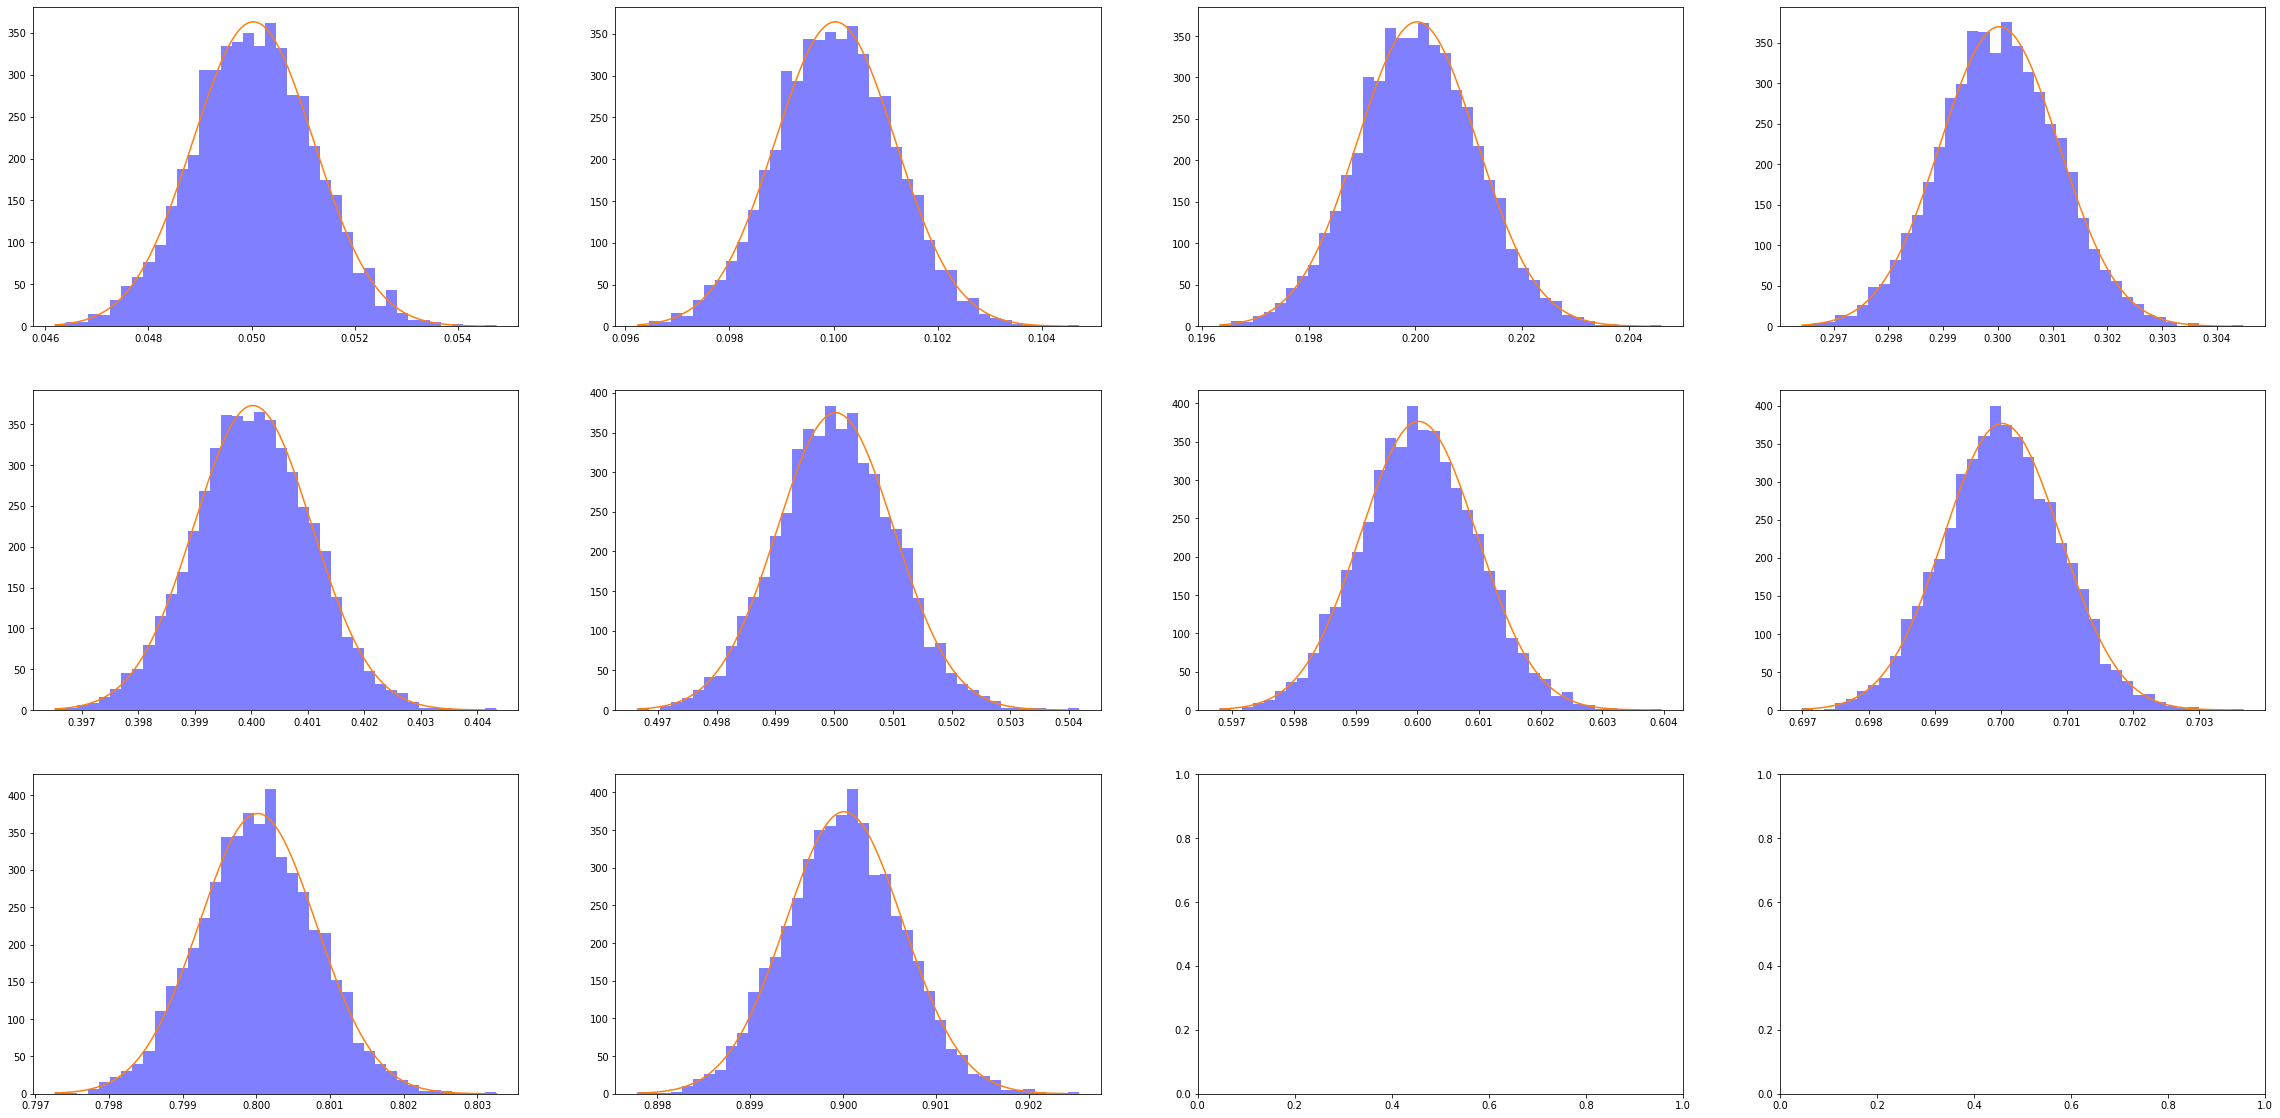

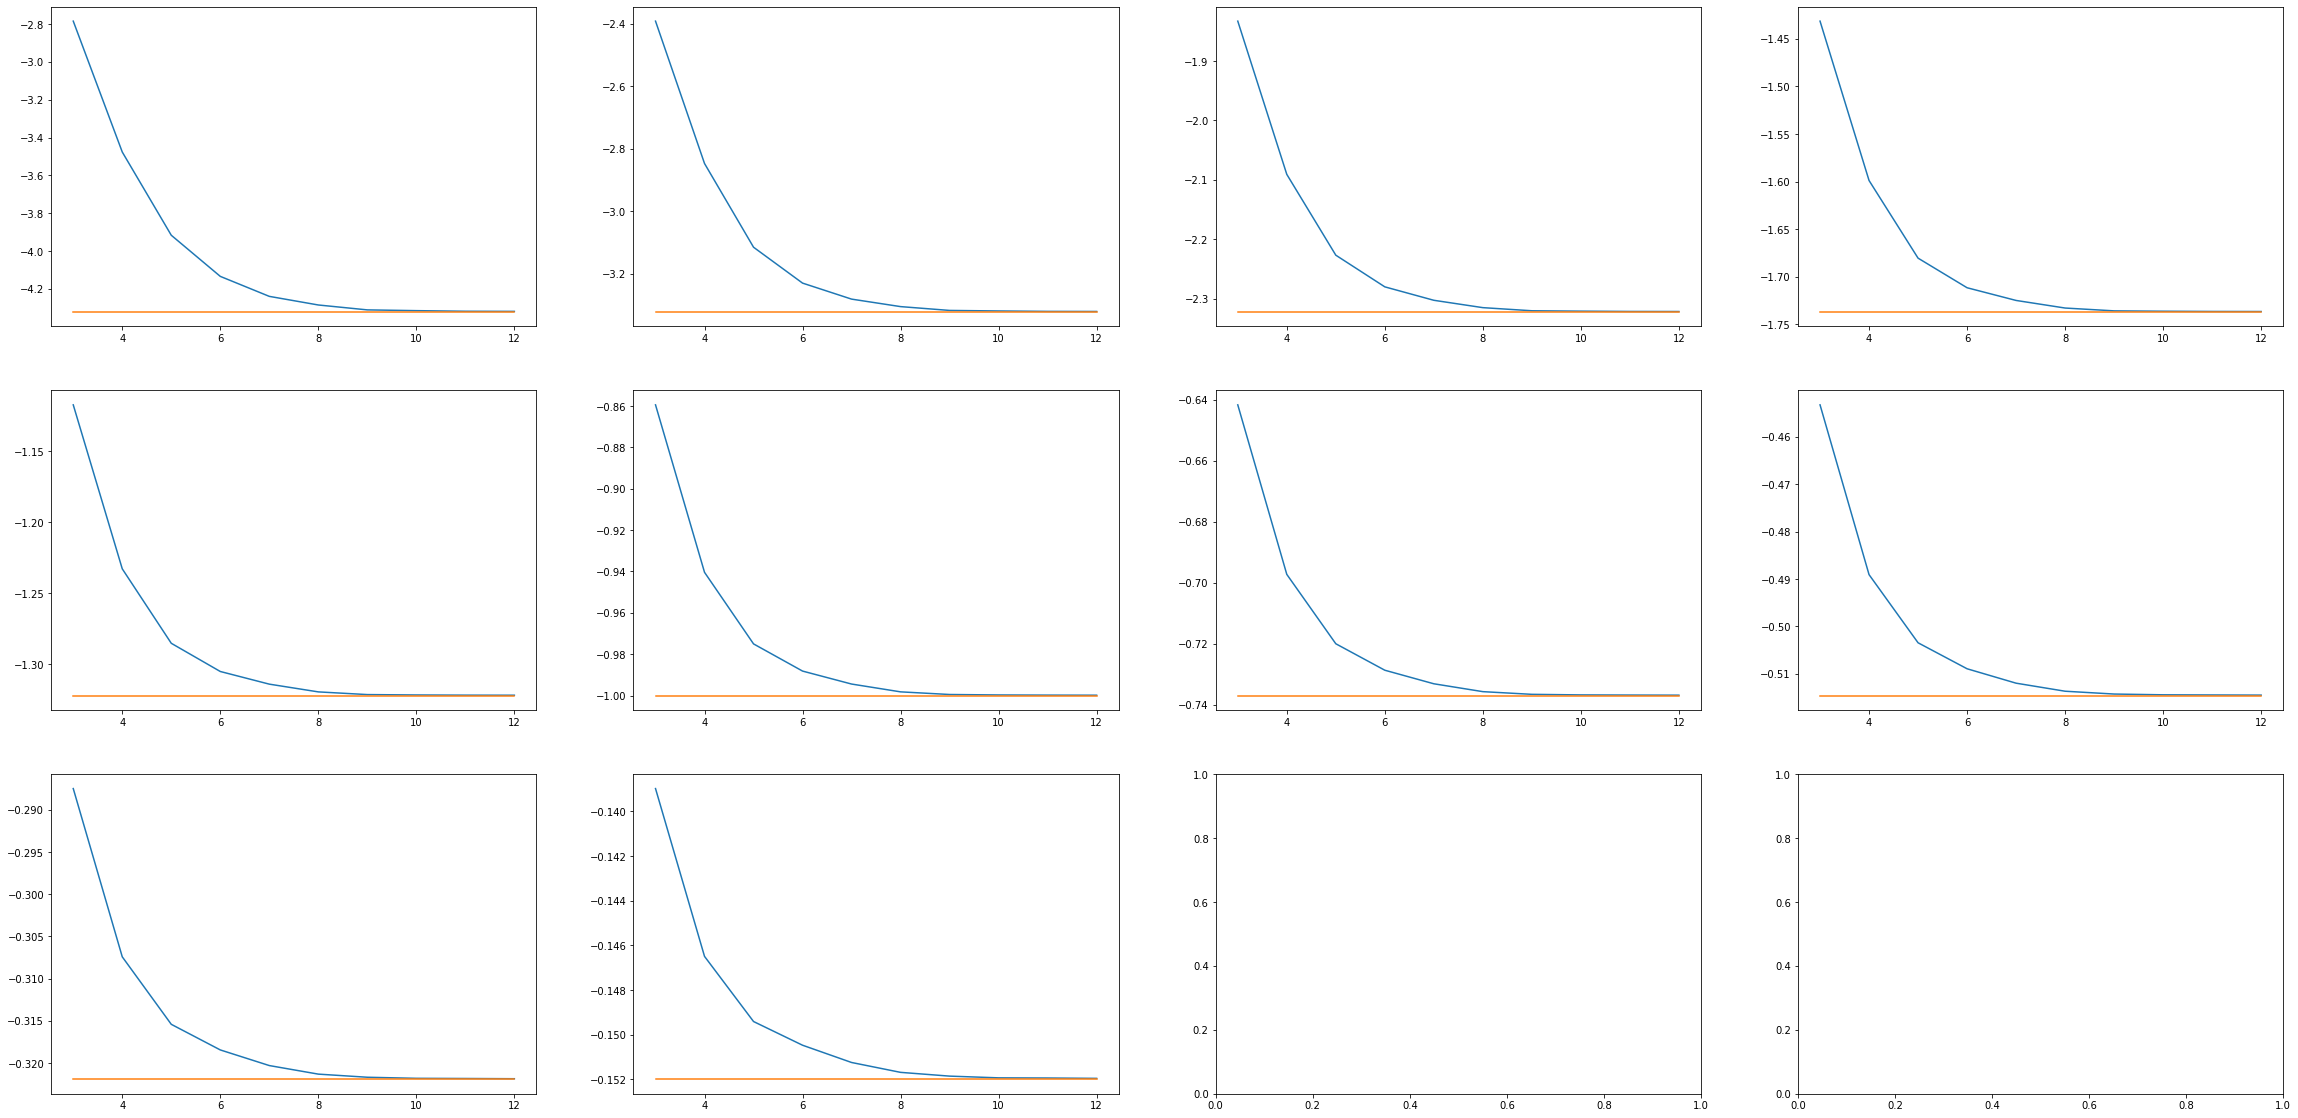

In [ ]:
coeur2.do_analysis()

In [ ]:
coeur2.norm_checks_LF

array([0.78698031, 0.61469435, 0.51744399, 0.51119077, 0.51030245,
       0.67198237, 0.78255637, 0.75501753, 0.23058497, 0.08829049])

### 4.4 Kubilius

In [ ]:
class Kubilius(estimator_master):
    def H_estimator(self, x):

        x = add_zero(x)
        path_diffs = second_order_diffs(x)

        sum = 0

        for i in range(path_diffs.shape[0] - 1):
            sum += 1 / (path_diffs.shape[0]) * (abs(path_diffs[i] + path_diffs[i+1]) /
            (abs(path_diffs[i + 1]) + abs(path_diffs[i])))

        return 1 / 0.1468 * (sum - 0.5174)


In [ ]:
kub = Kubilius(
    H_values = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 13,
)

0.05
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.1
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.2
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.3
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.4
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.5
0
1000
2000
3000
4000
0.6
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.7
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.8
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.9
Beginning Simulation
Covariance Done
0
1000
2000
3000
4000
0.05
Beginning Simulation
Covariance Done
0.1
Beginning Simulation
Covariance Done
0.2
Beginning Simulation
Covariance Done
0.3
Beginning Simulation
Covariance Done
0.4
Beginning Simulation
Covariance Done
0.5
0.6
Beginning Simulation
Covariance Done
0.7
Beginning Simulation
Covariance Done
0.8
Beginning Simulation
Covariance Done
0.9
Beginning Simulation
Covariance Done


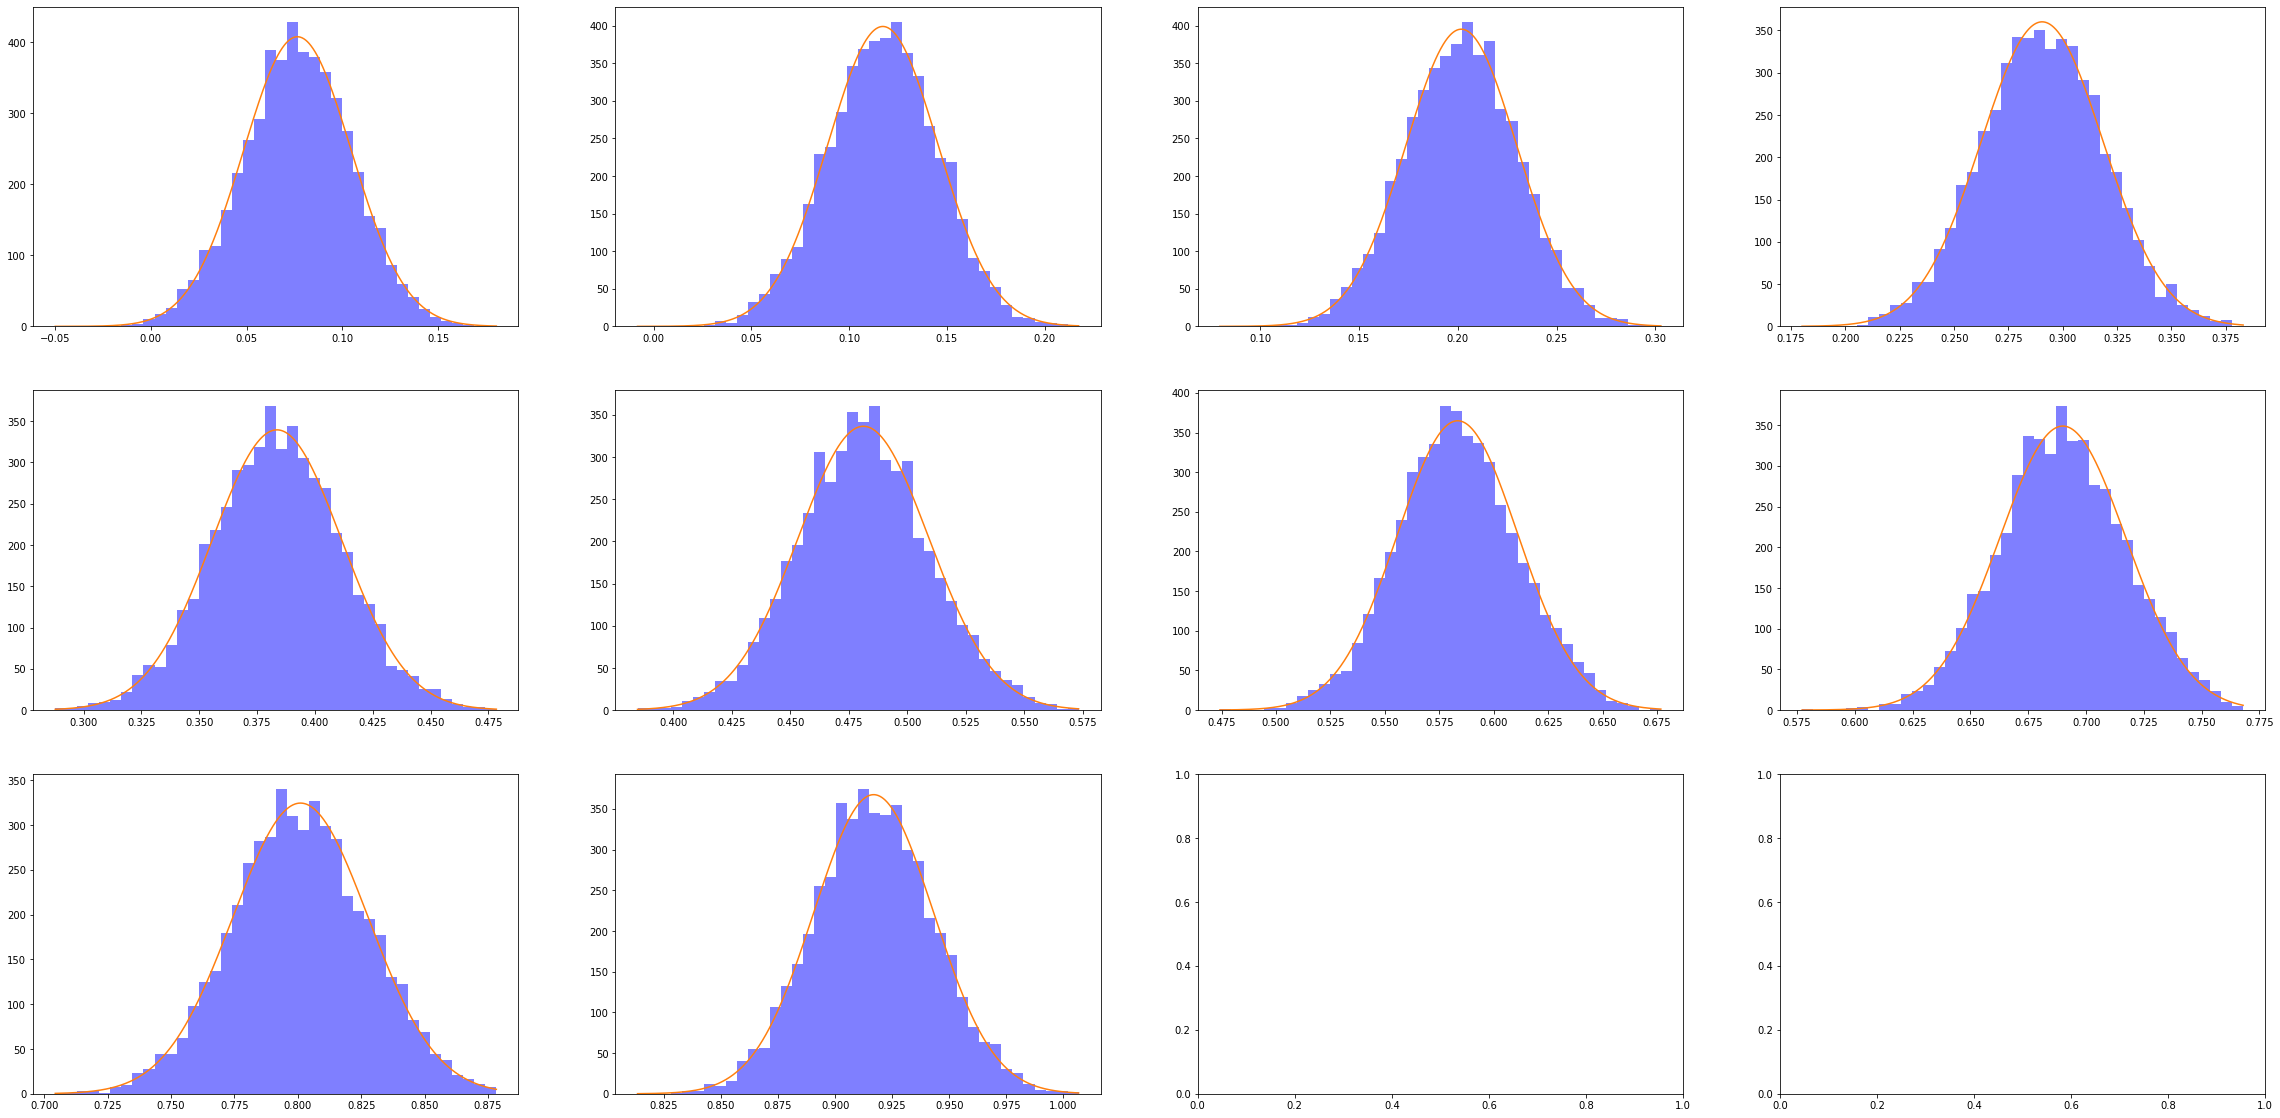

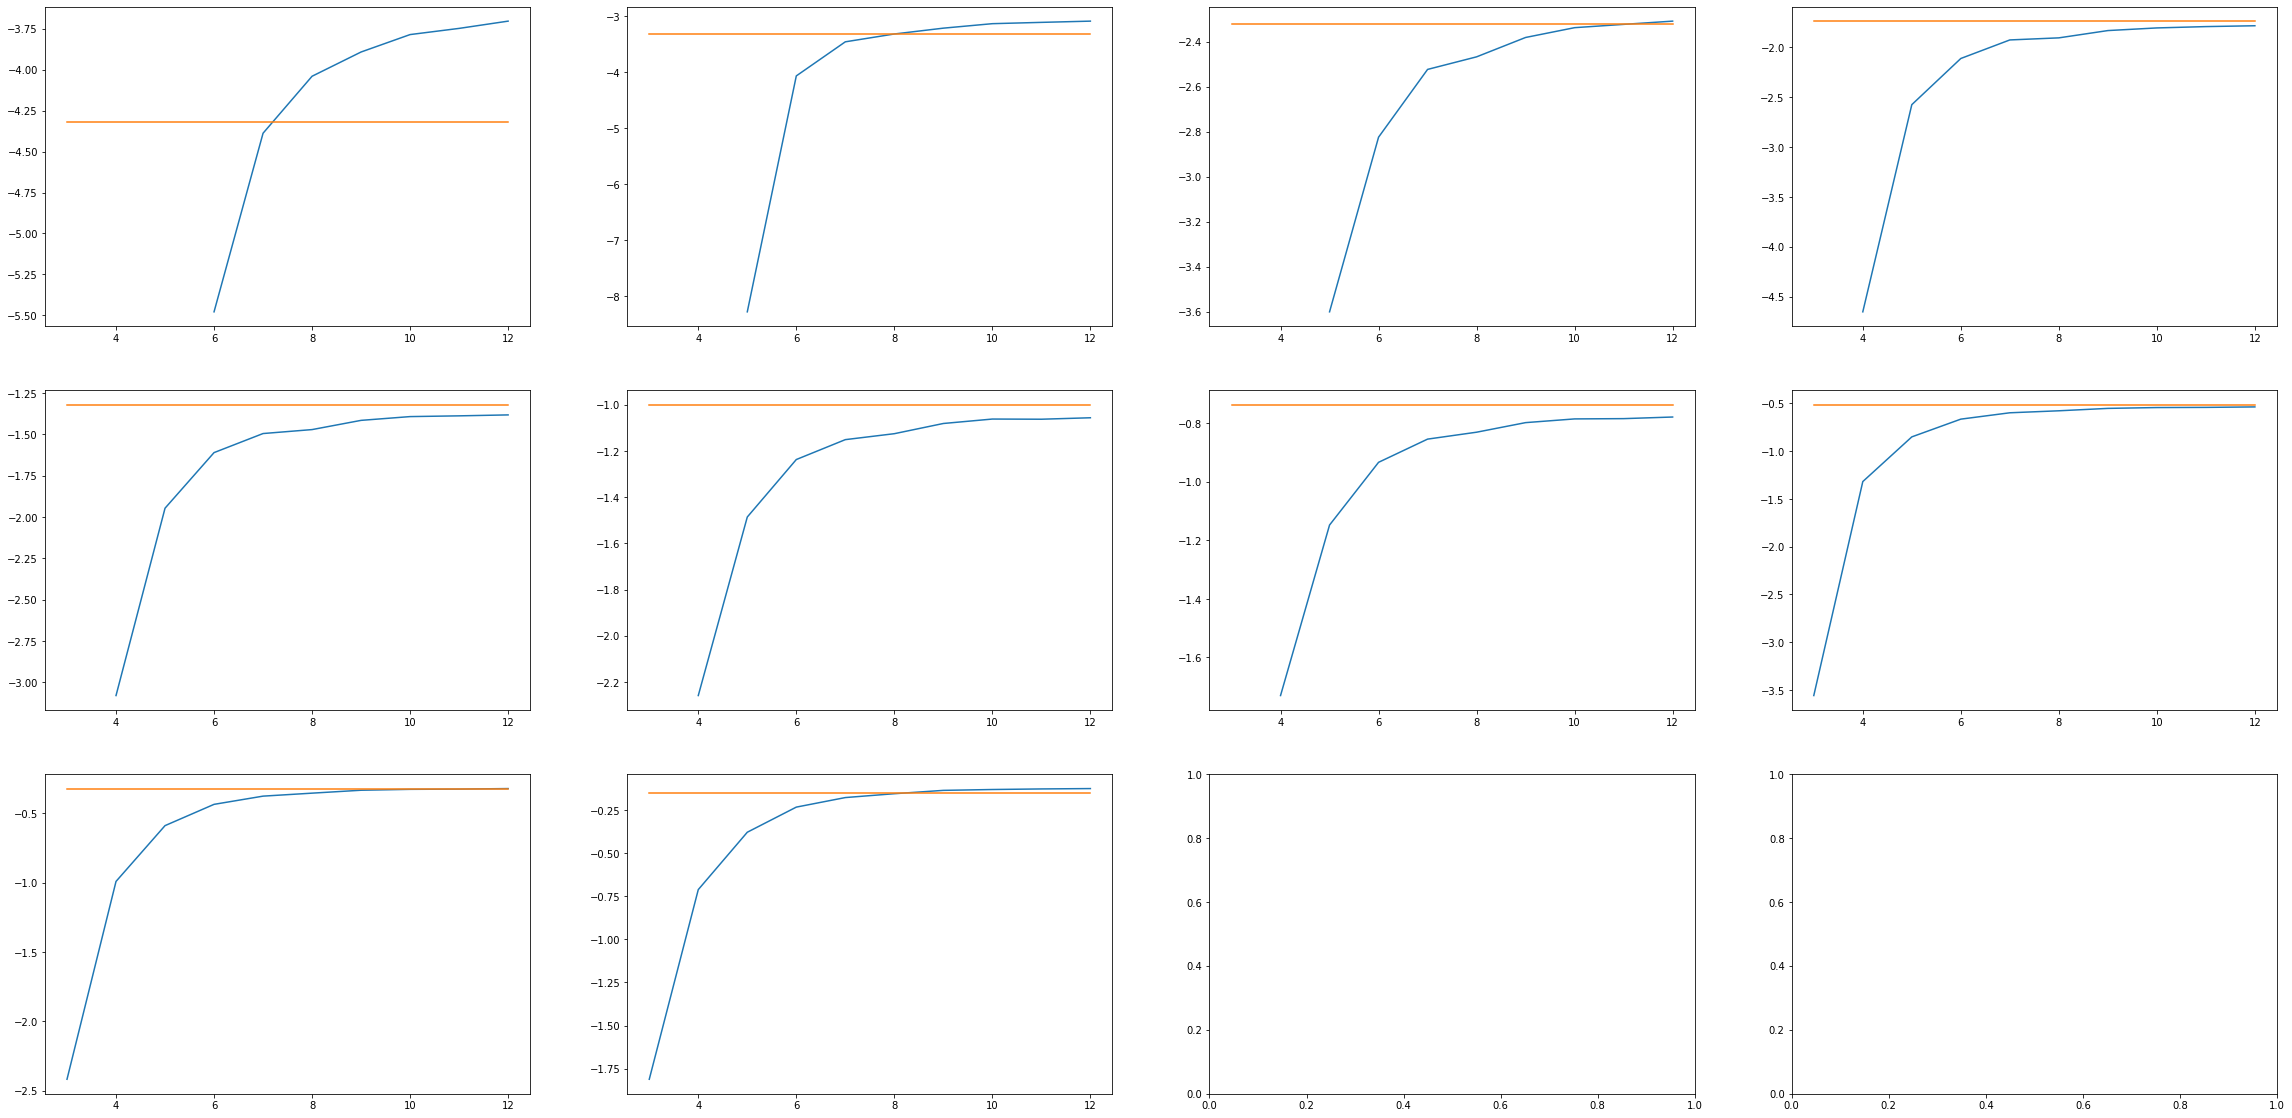

In [ ]:
kub.do_analysis()

In [ ]:
kub.df_analytics

,Mean,Variance
0.05,0.076505,0.000792
0.10,0.117196,0.000795
0.20,0.201776,0.000793
0.30,0.290477,0.000790
0.40,0.383591,0.000784
0.50,0.481276,0.000779
0.60,0.583399,0.000766
0.70,0.689948,0.000744
0.80,0.801055,0.000715
0.90,0.916888,0.000689


In [ ]:
kub.norm_checks_JB

array([0.5165968 , 0.48902914, 0.83062009, 0.78518277, 0.96556489,
       0.69807011, 0.31177651, 0.21946323, 0.09614222, 0.57291312])

In [ ]:
kub.norm_checks_LF

array([0.43066224, 0.44880931, 0.22777178, 0.57487375, 0.96143001,
       0.17933849, 0.05440654, 0.13268971, 0.18966385, 0.85244614])